### Still in progress

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [32]:
data_ml = pd.read_csv('data_ml.csv')

# 1 Data Inspection

In [33]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7030 entries, 0 to 7029
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7030 non-null   int64  
 1   gender            7030 non-null   object 
 2   SeniorCitizen     7030 non-null   object 
 3   Partner           7030 non-null   object 
 4   Dependents        7030 non-null   object 
 5   tenure            7030 non-null   int64  
 6   PhoneService      7030 non-null   object 
 7   MultipleLines     7030 non-null   object 
 8   InternetService   7030 non-null   object 
 9   OnlineSecurity    7030 non-null   object 
 10  OnlineBackup      7030 non-null   object 
 11  DeviceProtection  7030 non-null   object 
 12  TechSupport       7030 non-null   object 
 13  StreamingTV       7030 non-null   object 
 14  StreamingMovies   7030 non-null   object 
 15  Contract          7030 non-null   object 
 16  PaperlessBilling  7030 non-null   object 


In [34]:
#Checking levels of categorical features
for i in data_ml.columns:
    if data_ml[i].dtype == 'object':
        print(f'{i} {data_ml[i].unique()}')

gender ['Female' 'Male']
SeniorCitizen ['No' 'Yes']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


# 2 Feature Engineering

The dataset was partially processed during the exploratory data analysis (Part 1): Datatypes were changed. Redundant variables were deletet, outliers were and missing values were transformed (-> see Part 1: Exploratory Data Analysis)

## 2.1 Delete redundant variable

In [35]:
#Delete first column
data_ml = data_ml.iloc[:,1:]

In [36]:
#Seperate data into categorical features and numerical features 
data_cat = data_ml.select_dtypes(include=['object','category']).copy()
data_num = data_ml.select_dtypes(include=['float64','int64']).copy()

## 2.2 One Hot Encoding

In [37]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

#instantiate and fit One Hot Encoder with categorical features
ohe = OneHotEncoder(drop='first', sparse_output=False)
data_cat_encoded = ohe.fit_transform(data_cat)

#Generate Dataframe with encoded categorical features
feature_names = ohe.get_feature_names_out(input_features=data_cat.columns)
data_cat_df = pd.DataFrame(data_cat_encoded, columns=feature_names, index=data_cat.index)

#Concat encoded categorical features with numerical features
data_trans = pd.concat([data_cat_df, data_num], axis=1)

## 2.3 Train Test Split

In [38]:
from sklearn.model_selection import train_test_split

#Train/Test Split
X = data_trans.drop(columns='Churn_Yes')
y = data_trans['Churn_Yes']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=123)

In [39]:
# Check Stratify
print('y_train',y_train.value_counts(normalize=True))
print('y_test',y_test.value_counts(normalize=True))

y_train Churn_Yes
0.0    0.735953
1.0    0.264047
Name: proportion, dtype: float64
y_test Churn_Yes
0.0    0.736131
1.0    0.263869
Name: proportion, dtype: float64


## 2.4 Quantile Transforming

Quantile transformation of the features 'MonthlyCharges' and 'Total Charges' and 'tenure
.fit_transform of X_train and .transform of X_test to avoid data leakage

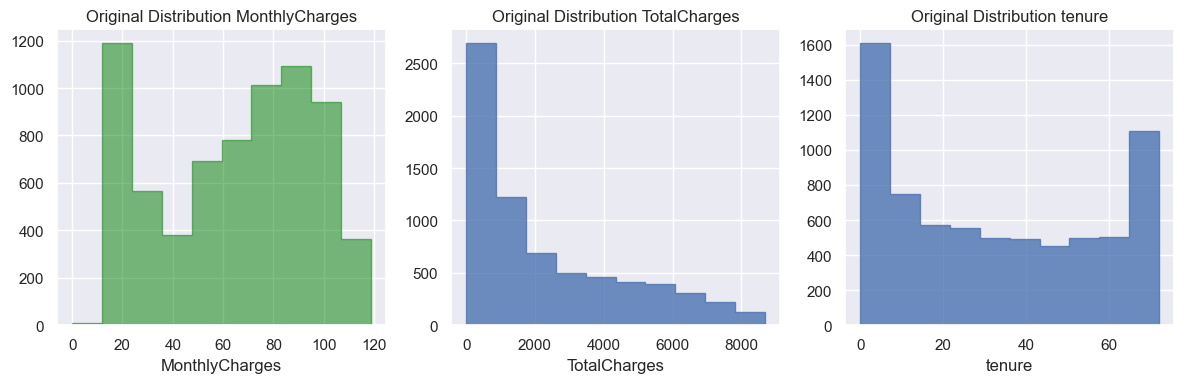

In [40]:
#Plot original distribution of Monthly and Total Charges

def dist_before_quantile():

    fig, ax = plt.subplots(1,3,figsize=(12,4))

    #Subplot 1: Monthlycharges
    data_ml.MonthlyCharges.hist(ax=ax[0],histtype='step',fill=True,color='green',alpha=0.5)
    ax[0].set_title('Original Distribution MonthlyCharges')
    ax[0].set_xlabel('MonthlyCharges')
    ax[0].set_ylabel=('Count')

    #Subplot 2: Totalcharges
    data_ml.TotalCharges.hist(ax=ax[1],histtype='step',fill=True,alpha=0.8)
    ax[1].set_title('Original Distribution TotalCharges')
    ax[1].set_xlabel('TotalCharges')
    ax[1].set_ylabel=('Count')

    #Subplot 3: tenure
    data_ml.tenure.hist(ax=ax[2],histtype='step',fill=True,alpha=0.8)
    ax[2].set_title('Original Distribution tenure')
    ax[2].set_xlabel('tenure')
    ax[2].set_ylabel=('Count')

    plt.tight_layout()

dist_before_quantile()

In [41]:
#Quantile Transforming

from sklearn.preprocessing import QuantileTransformer

#Instantiate Quantile Transformer
quantile_normal = QuantileTransformer(output_distribution='normal')

# Fit Transform X_train
X_train[['MonthlyCharges','TotalCharges','tenure']] = quantile_normal.fit_transform(X_train[['MonthlyCharges','TotalCharges','tenure']])

#Transform X_test
X_test[['MonthlyCharges','TotalCharges','tenure']] = quantile_normal.transform(X_test[['MonthlyCharges','TotalCharges','tenure']])

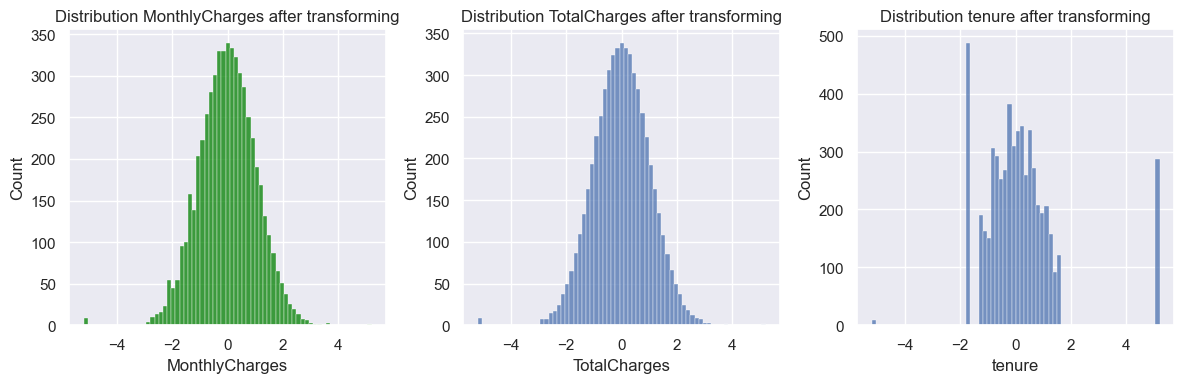

In [42]:
#Plot distribution after transforming

def dist_after_quantile():
    fig, ax = plt.subplots(1,3,figsize=(12,4))

    #Subplot 1: transformed MonthlyCharges
    sns.histplot(X_train.MonthlyCharges,ax=ax[0],color='green')
    ax[0].set_title('Distribution MonthlyCharges after transforming')
    ax[0].set_xlabel('MonthlyCharges')
    ax[0].set_ylabel=('Count')

    #Subplot 2: transformed TotalCharges
    sns.histplot(X_train.TotalCharges,ax=ax[1])
    ax[1].set_title('Distribution TotalCharges after transforming')
    ax[1].set_xlabel('TotalCharges')
    ax[1].set_ylabel=('Count')

    #Subplot 3: transformed TotalCharges
    sns.histplot(X_train.tenure,ax=ax[2])
    ax[2].set_title('Distribution tenure after transforming')
    ax[2].set_xlabel('tenure')
    ax[2].set_ylabel=('Count')

    plt.tight_layout()

dist_after_quantile()

## 2.5 Class Balancing

In [43]:
#Original Distribution target 'Churn'
data_ml.Churn.value_counts(normalize=True)

Churn
No     0.735989
Yes    0.264011
Name: proportion, dtype: float64

In [44]:
#Oversampling/Undersampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE()
under = RandomUnderSampler()
steps = [('o',over),('u',under)]
pipeline = Pipeline(steps=steps)
X_train_bal, y_train_bal = pipeline.fit_resample(X_train,y_train)


#https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [45]:
y_train_bal.value_counts()

Churn_Yes
0.0    4139
1.0    4139
Name: count, dtype: int64

# 3 Training

In [46]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
from sklearn.model_selection import ValidationCurveDisplay

## 3.1 Metric

Goal is to keep as much as customers as possible. Therefore, recall would be the best metric for this. It answers the question, how good the model is in predicting customers which are truly churned.

Recall (True Positive Rate) = True Positive / true positive + false negative

## 3.2 Model 1: Logistic Regression

In [47]:
#Instantiate LogisticRegression
lr = LogisticRegression(solver='saga',max_iter=1000)

#Dictionary for hyperparameter tuning
lr_param_dict = {'penalty':['l1','l2'],'C':[0.001, 0.01, 0.1]}

#Instantiate GridsearchCV
gridcv_lr = GridSearchCV(estimator=lr,cv=5,param_grid=lr_param_dict,scoring='recall')

#Fit Gridsearch with balanced Classes
model_lr = gridcv_lr.fit(X_train_bal,y_train_bal)

#Best params
print(f'best params: {model_lr.best_params_}')

#Best score
print(f'best recall: {model_lr.best_score_} \n')

best params: {'C': 0.1, 'penalty': 'l1'}
best recall: 0.8139638060856713 



## 3.3 Model 2: K Nearest Neighbors

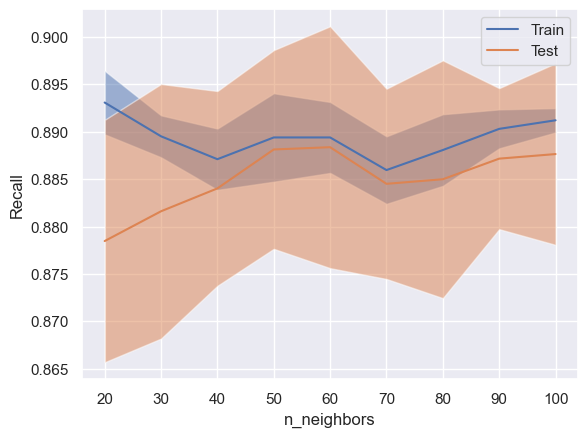

In [48]:
ValidationCurveDisplay.from_estimator(
   KNeighborsClassifier(), X_train_bal, y_train_bal,
       param_name="n_neighbors", param_range=[20,30,40,50,60,70,80,90,100],scoring='recall')

In [49]:
#Instantiate KNN
knn = KNeighborsClassifier()

#Dictionary for hyperparameter tuning
neighbors_range = range(60,100)
#knn_param_dict = {'n_neighbors':neighbors_range}

knn_param_dict = {
    'n_neighbors': neighbors_range,
    #'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan','hamming'],  
    #'leaf_size': [10, 20, 30],
}

#Instantiate GridsearchCV
gridcv_knn = GridSearchCV(estimator=knn,cv=5,param_grid=knn_param_dict,scoring='recall')

#Fit Gridsearch with training data
model_knn = gridcv_knn.fit(X_train_bal,y_train_bal)

#Best params
print(f'best params: {model_knn.best_params_}')

#Best score
print(f'best recall: {model_knn.best_score_} \n')

print(model_knn.cv_results_['mean_test_score'])

best params: {'metric': 'euclidean', 'n_neighbors': 61}
best recall: 0.8936932279527305 

[0.88837747 0.89369323 0.8886193  0.89175998 0.88644539 0.88886114
 0.88451273 0.88741187 0.8837878  0.88765341 0.88451273 0.88789525
 0.88475399 0.88789496 0.88354538 0.88837776 0.88451215 0.88813621
 0.88402876 0.88765312 0.88499553 0.88789467 0.88427089 0.88789467
 0.88572017 0.8881365  0.88620384 0.88934453 0.8859623  0.89006916
 0.88717003 0.89103622 0.88765341 0.89127748 0.88765341 0.89055284
 0.88765283 0.89103564 0.88716974 0.89031042 0.85213857 0.86011163
 0.85455432 0.85987038 0.85382998 0.85987009 0.85624631 0.86083656
 0.8567294  0.86131965 0.85576293 0.86011192 0.85648757 0.85987038
 0.85648757 0.86035318 0.85745375 0.86059472 0.85769617 0.8615612
 0.85817926 0.86180362 0.85721366 0.86156207 0.85793772 0.86228671
 0.86011192 0.86228613 0.86011192 0.86252767 0.86083685 0.86397724
 0.86180245 0.86397666 0.86107723 0.86397637 0.86156061 0.86494313
 0.86349357 0.86663483 0.77433947 0.7859

## 3.4 Model 3: Support Vector Machines

In [50]:
#Instantiate Support Vector Classifier
svm = SVC(probability=True)

#Dictionary for hyperparameter tuning
svm_param_dict = {
    'C': [0.01,0.1], #0.001 removed
    'kernel': ['linear','rbf'], #poly removed to save runtime
    'gamma': ['scale', 'auto']} #0.1 and 0.001 removed

#Instantiate GridsearchCV
gridcv_svm = GridSearchCV(estimator=svm,cv=5,param_grid=svm_param_dict,scoring='recall')

#Fit Gridsearch with training data
model_svm = gridcv_svm.fit(X_train_bal,y_train_bal)

# Best params
print(f'best params: {model_svm.best_params_}')

#Best score
print(f'best recall: {model_svm.best_score_} \n')

print(gridcv_svm.cv_results_['mean_test_score'])

best params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
best recall: 0.8277351348509543 

[0.82000245 0.79729334 0.82000245 0.80550736 0.82773513 0.80937151
 0.82773513 0.81058012]


## 3.5 Model 4: Random Forest

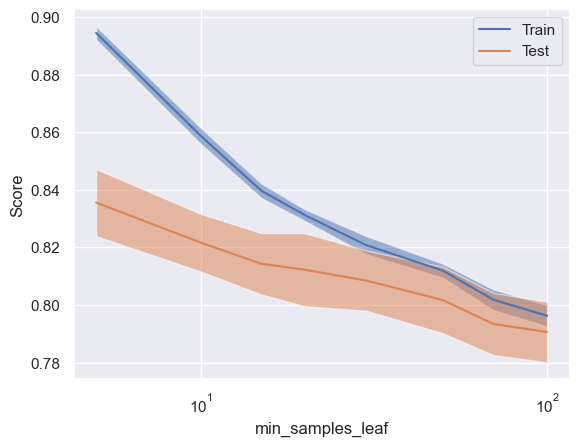

In [51]:
from sklearn.model_selection import ValidationCurveDisplay

ValidationCurveDisplay.from_estimator(
   RandomForestClassifier(
       random_state=123), X_train_bal, y_train_bal, 
       param_name="min_samples_leaf", param_range=[5,10,15,20,30,50,70,100])

In [52]:
#Instantiate Random Forest
rf = RandomForestClassifier(n_jobs=-1,random_state=123)

#Dictionary for hyperparameter tuning
rf_param_dict = {
    'max_depth': [15],
    'min_samples_leaf':[15,30,50,70],
    'max_features': ['sqrt',2,3,4,5] #mtry
}

#Instantiate GridsearchCV
gridcv_rf = GridSearchCV(estimator=rf,cv=5,param_grid=rf_param_dict,scoring='recall')

#Fit Gridsearch with training data
model_rf = gridcv_rf.fit(X_train_bal,y_train_bal)

# Best params
print(f'best params: {model_rf.best_params_}')

#Best score
print(f'best recall: {model_rf.best_score_} \n')


print(model_rf.cv_results_['mean_test_score'])

best params: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 15}
best recall: 0.8335348649738009 

[0.83353486 0.8272538  0.81879735 0.80575008 0.83014972 0.82483542
 0.82652448 0.82821823 0.8284589  0.81855464 0.81347984 0.81541279
 0.83280818 0.81783    0.81372051 0.80937502 0.83353486 0.8272538
 0.81879735 0.80575008]


# 4 Best Model

### 4.1 Training

In [53]:
best_model = KNeighborsClassifier(**model_knn.best_params_)

best_model.fit(X_train_bal,y_train_bal)

KNeighborsClassifier(metric='euclidean', n_neighbors=61)

### 4.2 Evaluation

In [54]:
#Test best model
y_pred_best = best_model.predict(X_test)
print('test:',recall_score(y_test,y_pred_best))

#Check overfitting
y_pred_best_train = best_model.predict(X_train)
print('train (overfitting):',recall_score(y_train,y_pred_best_train))

test: 0.8679245283018868
train (overfitting): 0.8801346801346801


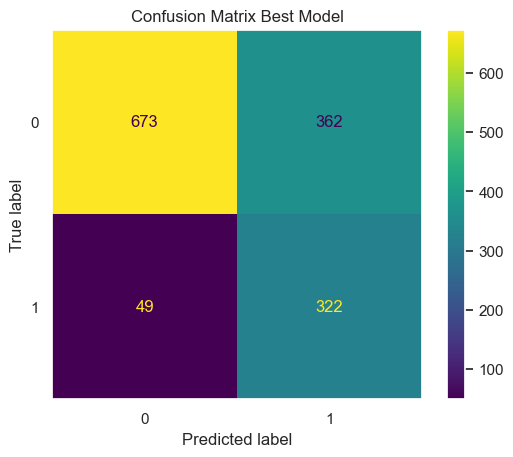

In [55]:
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix Best Model')
plt.grid()

In [56]:
print('accuracy_score:' ,accuracy_score(y_test,y_pred_best))
print('recall_score:', recall_score(y_test,y_pred_best))
print('precision_score:', precision_score(y_test,y_pred_best))
print('f1_score:', f1_score(y_test,y_pred_best))
print('roc_auc_score:', roc_auc_score(y_test,y_pred_best))

accuracy_score: 0.7076813655761024
recall_score: 0.8679245283018868
precision_score: 0.47076023391812866
f1_score: 0.6104265402843602
roc_auc_score: 0.7590830370978033


In [57]:
#Cross Validation Default Model
from sklearn.model_selection import cross_val_score

scores = cross_val_score(knn, X_train_bal, y_train_bal, cv=5,scoring='recall')
print('cross validation scores:',scores)

#Instantiating default model
knn_model_default = KNeighborsClassifier()

#Fitting default model
knn_model_default.fit(X_train_bal,y_train_bal)

#Test Default model default
y_pred_default = knn_model_default.predict(X_test)
print('test:',recall_score(y_test,y_pred_default))

#Check overfitting 
y_pred_default_train = knn_model_default.predict(X_train)
print('train (overfitting):',recall_score(y_train,y_pred_default_train))

cross validation scores: [0.92874396 0.92270531 0.93357488 0.91293833 0.9178744 ]
test: 0.7142857142857143
train (overfitting): 0.9367003367003367


In [58]:
y_pred_proba = best_model.predict_proba(X_test)

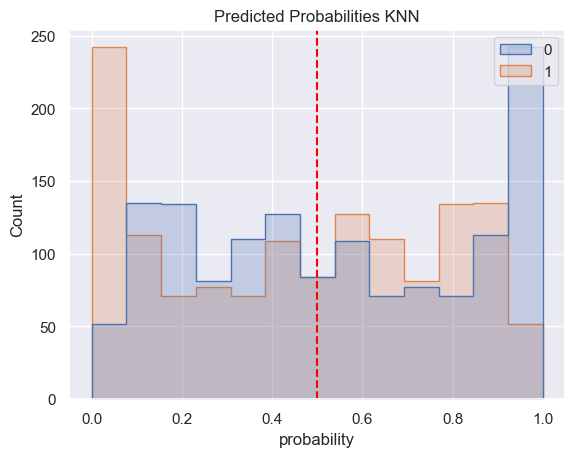

In [59]:
sns.histplot(y_pred_proba,element='step')
plt.xlabel('probability')
plt.title('Predicted Probabilities KNN')
plt.axvline(0.5,linestyle='--',color='red');

c:\Users\flori\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\flori\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


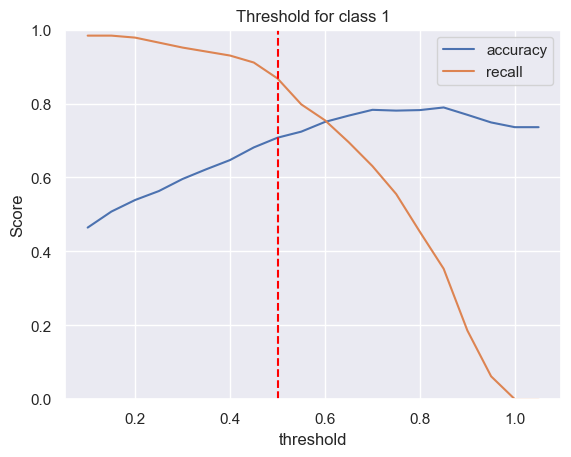

In [60]:
threshold_range = np.arange(0.1,1.1,0.05)

accuracy_proba_test = []
recall_proba_test = []
precision_proba_test = []
f1_proba_test = []
roc_auc_proba_test = []

for threshold in threshold_range:
    y_test_pred = [1 if x >= threshold else 0 for x in y_pred_proba[:, 1]]

    accuracy_proba_test.append(accuracy_score(y_test, y_test_pred))
    recall_proba_test.append(recall_score(y_test, y_test_pred))
    precision_proba_test.append(precision_score(y_test, y_test_pred))
    f1_proba_test.append(f1_score(y_test, y_test_pred))
    roc_auc_proba_test.append(roc_auc_score(y_test, y_test_pred))


sns.lineplot(x=threshold_range,y=accuracy_proba_test,label='accuracy')
sns.lineplot(x=threshold_range,y=recall_proba_test,label='recall')
#sns.lineplot(x=threshold_range,y=precision_proba_test,label='precision')
#sns.lineplot(x=threshold_range,y=f1_proba_test,label='f1',color='y')
#sns.lineplot(x=threshold_range,y=roc_auc_proba_test,label='roc_auc',color='black')


plt.xlabel('threshold')
plt.ylabel('Score')
plt.title('Threshold for class 1')
plt.ylim(0,1);
plt.axvline(0.5,linestyle='--',color='red')
#plt.text(0.25,0.9,'Threshold 0.5',color='red');

In [61]:
roc_auc_threshold_df = pd.DataFrame({'Threshold':threshold_range,
                                     'Recall':recall_proba_test,
                                     'Accuracy':accuracy_proba_test,
                                     'Precison':precision_proba_test,
                                     'roc_auc':roc_auc_proba_test,})
roc_auc_threshold_df.sort_values(by='Threshold',ascending=False)

,Threshold,Recall,Accuracy,Precison,roc_auc
19,1.05,0.000000,0.736131,0.000000,0.500000
18,1.00,0.000000,0.736131,0.000000,0.500000
17,0.95,0.061995,0.748933,0.821429,0.528582
16,0.90,0.185984,0.769559,0.758242,0.582364
15,0.85,0.353100,0.789474,0.700535,0.649497
14,0.80,0.452830,0.782361,0.619926,0.676657
13,0.75,0.555256,0.780939,0.590258,0.708546
12,0.70,0.630728,0.783073,0.582090,0.734204
11,0.65,0.695418,0.767425,0.546610,0.744327
10,0.60,0.754717,0.750356,0.518519,0.751755


### 4.3 Feature Selection

In [62]:
sbs_best_model = SequentialFeatureSelector(estimator=model_knn.best_estimator_,
                                   forward=False,
                                   floating=False,
                                   scoring='recall',
                                   k_features=3)

sbs_best_model.fit(X_train_bal,y_train_bal)

SequentialFeatureSelector(estimator=KNeighborsClassifier(metric='euclidean',
                                                         n_neighbors=61),
                          forward=False, k_features=(3, 3), scoring='recall')

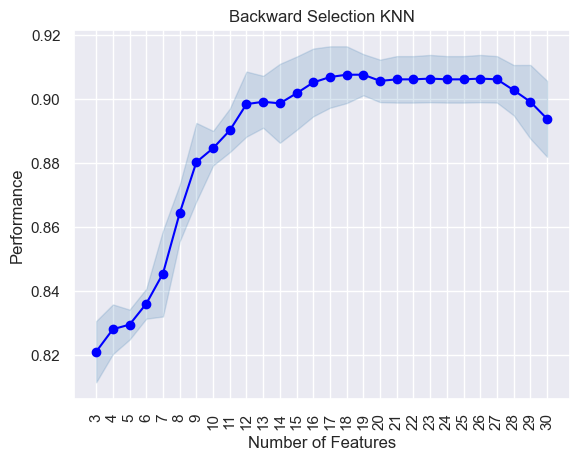

In [63]:
#Plot Performance
plot_sfs(sbs_best_model.get_metric_dict())
plt.title('Backward Selection KNN')
plt.xticks(rotation=90);

In [67]:
avg_score = [sbs_best_model.subsets_[i]['avg_score'] for i in range(3,30)]
n_features = [len(sbs_best_model.subsets_[i]['feature_names']) for i in range(3,30)]

sbs_performance_rf = pd.DataFrame({'n_features': n_features,
                                   'avg_recall': avg_score}) \
.sort_values(by='avg_recall',ascending=False) \
.reset_index(drop=True)

sbs_performance_rf[sbs_performance_rf['avg_recall'] > 0.90]

,n_features,avg_recall
0,18,0.907465
1,19,0.907465
2,17,0.906740
3,26,0.906258
4,23,0.906258
5,27,0.906016
6,25,0.906016
7,24,0.906016
8,22,0.906016
9,21,0.906016


In [70]:
print(sbs_best_model.subsets_[18]['cv_scores'])

[0.90338164 0.89492754 0.91183575 0.90568319 0.92149758]


In [75]:
for i, feature in enumerate(sbs_best_model.subsets_[18]['feature_names']):
    print(f'{i} {feature}')

0 gender_Male
1 Partner_Yes
2 Dependents_Yes
3 PhoneService_Yes
4 MultipleLines_No phone service
5 MultipleLines_Yes
6 OnlineBackup_Yes
7 DeviceProtection_Yes
8 TechSupport_Yes
9 StreamingTV_Yes
10 StreamingMovies_Yes
11 Contract_One year
12 Contract_Two year
13 PaperlessBilling_Yes
14 PaymentMethod_Credit card (automatic)
15 PaymentMethod_Mailed check
16 tenure
17 MonthlyCharges
